In [2]:
# importing helper libraries
import numpy as np
import pandas as pd
# import machine learning libraries
import tensorflow as tf
from tensorflow import keras
# Importing data preprocessing techniques
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

2024-05-18 13:32:00.011142: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-18 13:32:00.539512: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Data Reading, Downloaded from Yahoo Finance

In [3]:
data = pd.read_csv("../BTC-USD.csv")
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [4]:
data.isna().astype("int").sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [5]:
# we need to remove null or NaN value from our dataset
data.dropna(inplace = True)
data.isna().astype("int").sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [6]:
required_data = data[["High", "Low", "Close"]]
required_data.head()

,High,Low,Close
0,468.174011,452.421997,457.334015
1,456.859985,413.104004,424.440002
2,427.834991,384.532013,394.795990
3,423.295990,389.882996,408.903992
4,412.425995,393.181000,398.821014


# Data Preprocessing

In [7]:
train_data_length = int(0.9 * len(required_data))

In [8]:
# Before we normalize the data, we need to split the data into train and test split, so that data snooping can be
# avoided

train_data = required_data.iloc[:train_data_length]
test_data = required_data.iloc[train_data_length:]

print(f"Training data : {train_data.shape}")
print(f"Testing data : {test_data.shape}")

Training data : (3178, 3)
Testing data : (354, 3)


In [9]:
# Data Normalization
# This will scale the data between -1 and 1
normalizer = MinMaxScaler(feature_range = (-1, 1))
# Fit the normalizer on the train data only
normalizer.fit(train_data)


# converting the train data
train_data = normalizer.transform(train_data)
test_data  = normalizer.transform(test_data)

print(f"Training data : {train_data.shape}")
print(f"Testing data : {test_data.shape}")

Training data : (3178, 3)
Testing data : (354, 3)


In [10]:
# checking the range of train data and test data
print(f"Maximum and minimum value of training data : {np.max(train_data), np.min(train_data)}")
print(f"Maximum and minimum value of testing  data : {np.max(test_data), np.min(test_data)}")

Maximum and minimum value of training data : (1.0000000000000002, -1.0)
Maximum and minimum value of testing  data : (1.1637268508796232, -0.2596217620494885)


In [11]:
# this piece of code creates the data where features and targets are multivariate

def create_window_split_with_target_multivariate(data, window_size, horizon=1, stride=1):
    """
    Function to split a multivariate time series data into overlapping windows and generate target variables.
    
    Parameters:
        data (numpy.ndarray): The input multivariate time series data with shape (num_samples, num_features).
        window_size (int): Size of each window.
        horizon (int): Forecast horizon, i.e., number of future time steps to predict. Default is 1.
        stride (int): The stride or step size between consecutive windows. Default is 1.
    
    Returns:
        numpy.ndarray, numpy.ndarray: Arrays containing the split windows and corresponding target variables.
    """
    num_samples = len(data)
    num_features = data.shape[1]
    num_windows = (num_samples - window_size - horizon) // stride + 1
    windows = np.zeros((num_windows, window_size, num_features))
    targets = np.zeros((num_windows, num_features))
    
    for i in range(num_windows):
        start_index = i * stride
        end_index = start_index + window_size
        windows[i] = data[start_index:end_index]
        targets[i] = data[end_index + horizon - 1]  # Assuming the target is the value at the end of the forecast horizon
    
    return windows, targets


window_size = 15
horizon = 1
stride = 1

train_features, train_lables = create_window_split_with_target_multivariate(train_data, window_size, horizon, stride)
test_features, test_lables = create_window_split_with_target_multivariate(test_data, window_size, horizon, stride)


print(f"Training Data : {train_features.shape, train_lables.shape}")
print(f"Testing Data : {test_features.shape, test_lables.shape}")

Training Data : ((3163, 15, 3), (3163, 3))
Testing Data : ((339, 15, 3), (339, 3))


# Model Training and Evaluation

## GRU Models

Model 1: This model has 2 GRU layers with 128 units each and Group Normalization

In [12]:
from tensorflow.keras.layers import GRU

gru1 = tf.keras.Sequential(
    [
        keras.layers.Input(shape = (15, 3)),
        keras.layers.Bidirectional(GRU(units = 128, activation = "gelu", return_sequences = True)),
        keras.layers.GroupNormalization(),
        keras.layers.Bidirectional(GRU(units = 128, activation = "gelu")),
        keras.layers.GroupNormalization(),
        keras.layers.Dense(units = 64, activation = "gelu"),
        keras.layers.Dense(units = 3, activation = "tanh")  
    ]
)
gru1.summary()

2024-05-18 13:32:07.745621: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-18 13:32:07.780819: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 15, 256)        │       102,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ group_normalization             │ (None, 15, 256)        │           512 │
│ (GroupNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 256)            │       296,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ group_normalization_1           │ (None, 256)            │           512 │
│ (GroupNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 416,259 (1.59 MB)

 Trainable params: 416,259 (1.59 MB)

 Non-trainable params: 0 (0.00 B)

detect if the model has converge early

Model 2: This model has 2 GRU layers with 32 units each and Layer Normalization

In [13]:
gru2 = tf.keras.Sequential(
    [
        keras.layers.Input(shape = (15, 3)),
        keras.layers.Bidirectional(GRU(units = 32, activation = "tanh", return_sequences = True)),
        keras.layers.LayerNormalization(),
        keras.layers.Bidirectional(GRU(units = 32, activation = "tanh")),
        keras.layers.LayerNormalization(),
        keras.layers.Dense(units = 32, activation = "tanh"),
        keras.layers.Dense(units = 3)  
    ]
)
gru2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional) │ (None, 15, 64)         │         7,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization             │ (None, 15, 64)         │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 64)             │        18,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_1           │ (None, 64)             │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,355 (110.76 KB)

 Trainable params: 28,355 (110.76 KB)

 Non-trainable params: 0 (0.00 B)

Model 3: RNN Model

In [33]:
rnn = tf.keras.Sequential(
    [
        keras.layers.Input(shape=(15, 3)),
        keras.layers.RNN(
            keras.layers.SimpleRNNCell(units=128, activation="gelu"),
            return_sequences=True
        ),
        keras.layers.GroupNormalization(),
        keras.layers.RNN(
            keras.layers.SimpleRNNCell(units=128, activation="gelu"),
        ),
        keras.layers.GroupNormalization(),
        keras.layers.Dense(units=64, activation="gelu"),
        keras.layers.Dense(units=3, activation="tanh")
    ]
)
rnn.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rnn (RNN)                       │ (None, 15, 128)        │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ group_normalization_2           │ (None, 15, 128)        │           256 │
│ (GroupNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rnn_1 (RNN)                     │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ group_normalization_3           │ (None, 128)            │           256 │
│ (GroupNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,755 (229.51 KB)

 Trainable params: 58,755 (229.51 KB)

 Non-trainable params: 0 (0.00 B)

In [59]:
callbacks = []
early_stops = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=40)
callbacks.append(early_stops)

In [60]:
gru1.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.001), loss = "mse", metrics = ["mse", "mae"])
gru2.compile(optimizer = keras.optimizers.AdamW(learning_rate = 0.001), loss = "mse", metrics = ["mse", "mae"])
rnn.compile(optimizer = keras.optimizers.AdamW(learning_rate = 0.001), loss = "mse", metrics = ["mse", "mae"])

In [61]:
history1 = gru1.fit(train_features, train_lables, epochs = 100, validation_split = 0.1, callbacks = callbacks)
history2 = gru2.fit(train_features, train_lables, epochs = 100, validation_split = 0.1, callbacks = callbacks)
history3 = rnn.fit(train_features, train_lables, epochs = 100, validation_split = 0.1, callbacks = callbacks)

Epoch 1/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 8.1481e-04 - mae: 0.0191 - mse: 8.1481e-04 - val_loss: 3.9279e-04 - val_mae: 0.0156 - val_mse: 3.9279e-04
Epoch 2/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4.2353e-04 - mae: 0.0107 - mse: 4.2353e-04 - val_loss: 3.7661e-04 - val_mae: 0.0145 - val_mse: 3.7661e-04
Epoch 3/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4.8026e-04 - mae: 0.0126 - mse: 4.8026e-04 - val_loss: 3.9247e-04 - val_mae: 0.0153 - val_mse: 3.9247e-04
Epoch 4/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4.9200e-04 - mae: 0.0118 - mse: 4.9200e-04 - val_loss: 3.6942e-04 - val_mae: 0.0150 - val_mse: 3.6942e-04
Epoch 5/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 5.9930e-04 - mae: 0.0126 - mse: 5.9930e-04 - val_loss: 2.9852e-04 - val_mae: 0.0125 - val_mse: 2.9852e-04
Epoch 6/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 5.2587e-04 - mae: 0.0125 - mse: 5.2587e-04 - val_loss: 4.5269e-04 - val_mae: 0.0157 - val_mse: 4.5269e-04
Epoc

In [62]:
gru1.evaluate(test_features, test_lables)
gru2.evaluate(test_features, test_lables)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0013 - mae: 0.0214 - mse: 0.0013         
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0017 - mae: 0.0304 - mse: 0.0017 


[0.003306763246655464, 0.003306763246655464, 0.040170855820178986]

In [63]:
test_predicts = gru1.predict(test_features)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


## Training progress

In [76]:
def plot_training_progress(histories, model_names):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    for history, name in zip(histories, model_names):
        train_loss = history.history["loss"]
        valid_loss = history.history["val_loss"]
        
        train_mae = history.history["mae"]
        valid_mae = history.history["val_mae"]
    
        axes[0].plot(range(len(valid_loss)), valid_loss, label=name)
        axes[1].plot(range(len(valid_mae)), valid_mae, label=name)
        axes[2].plot(range(len(train_loss)), train_loss, label=name)    
        axes[3].plot(range(len(train_mae)), train_mae, label=name)
    axes[0].set_title("Validation MSE vs Epochs")
    axes[1].set_title("Validation MAE vs Epochs")
    axes[2].set_title("Training MSE vs Epochs")
    axes[3].set_title("Training MAE vs Epochs")
    axes[0].set_ylabel("Loss value")
    for ax in axes:
        ax.set_xlabel("Epoch") 
    axes[0].legend()
    plt.show()

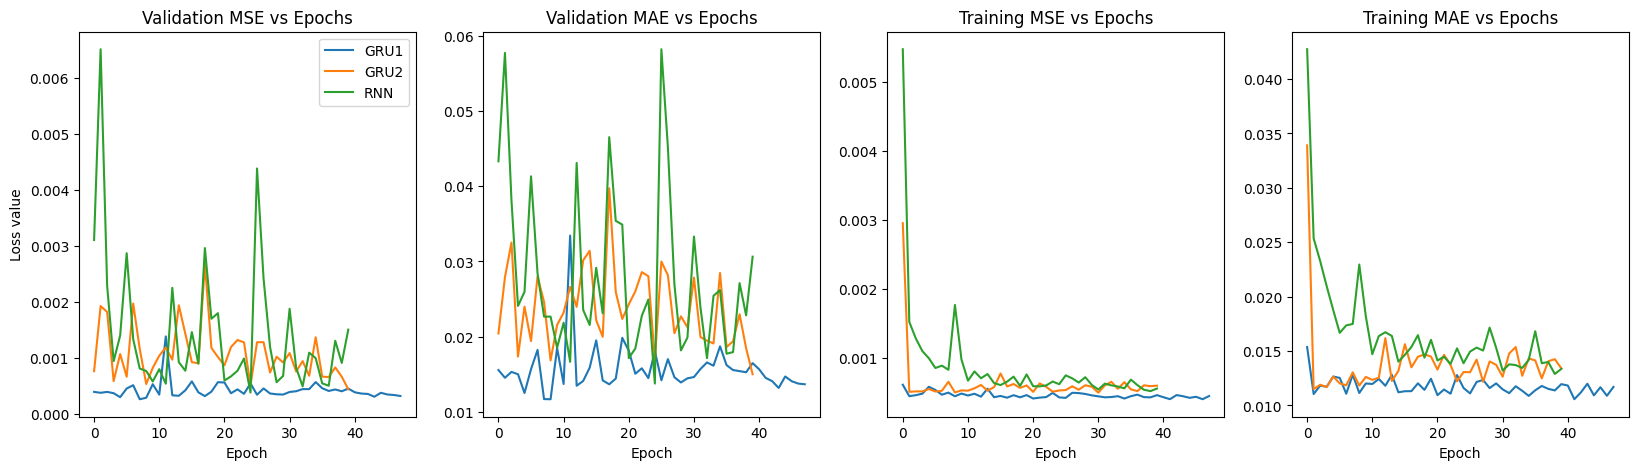

In [77]:
plot_training_progress([history1, history2, history3], ["GRU1", "GRU2", "RNN"])

save the best model

In [78]:
tf.keras.models.save_model(gru1, "../gru1.keras")

In [66]:
import matplotlib.pyplot as plt

In [67]:
def plot(models, model_names):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    # true values
    axes[0].plot(test_lables[:, 0], label = "True")
    axes[1].plot(test_lables[:, 1], label = "True")
    axes[2].plot(test_lables[:, 2], label = "True")
    for model, name in zip(models, model_names):
        test_predicts = model.predict(test_features)
        
        axes[0].plot(test_predicts[:, 0], label=name, linestyle="--")
        axes[0].set_title('High Value')
        axes[0].set_xlabel('Future Dates')
        axes[0].set_ylabel('Predicted values')
        
        axes[1].plot(test_predicts[:, 1], label=name, linestyle="--")
        axes[1].set_title('Low Value')
        axes[1].set_xlabel('Future Dates')
        axes[1].set_ylabel('Predicted values')
        
        axes[2].plot(test_predicts[:, 2], label=name, linestyle="--")
        axes[2].set_title('Close Value')
        axes[2].set_xlabel('Future Dates')
        axes[2].set_ylabel('Predicted values')
    for ax in axes:
        ax.legend()
    plt.show()

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


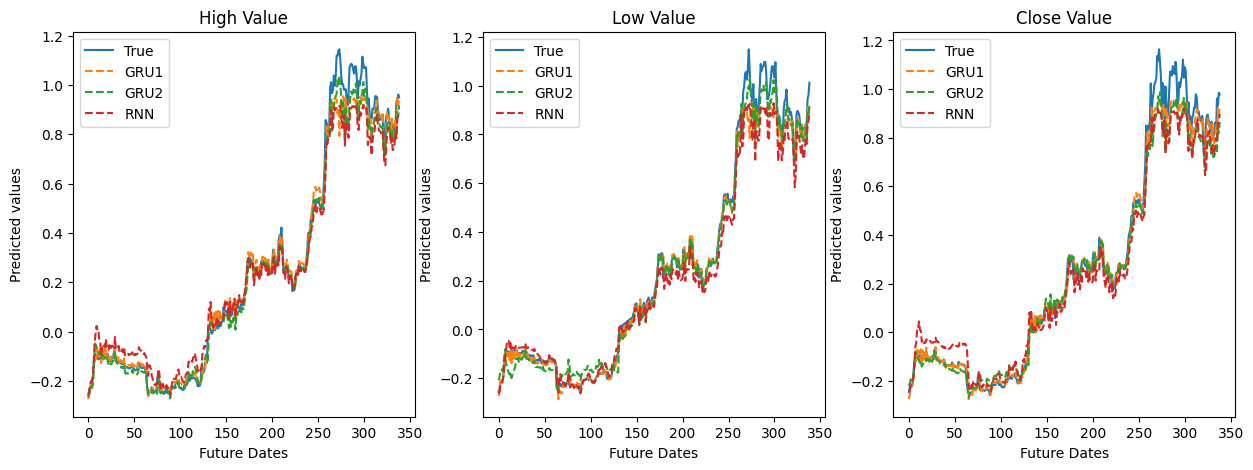

In [69]:
plot([gru1, gru2, rnn], ["GRU1", "GRU2", "RNN"])


In [25]:
import tensorflow as tf

In [26]:
tf.__version__

'2.16.1'